# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal, stats, special
from cycler import cycler
from scipy.optimize import curve_fit

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib inline

# Data structure

In [3]:
simulations = [{'label' : 'Al1', 'i' : 1, 'Sc': 0.7, 'Rl' :60, 'N': 128, 'Urms' : 0.15E-1, 'L' : 2.12, 'folder' : 'N128/Rl60_Sc07/', 'runs' : [795], 'spec_ite' : 500000, 'h5_ite' : 500000},
               #{'label' : 'Al2', 'i' : 1, 'Sc': 0.7, 'Rl' :60, 'N': 128, 'Urms' : 0.22E-1, 'L' : 2.1, 'folder' : 'N128/Rl60_Sc07_alvelius2/', 'runs' : [416], 'spec_ite' : 520000, 'h5_ite' : 500000},
               #{'label' : r'Big box', 'i' : 1, 'Sc': 1.0, 'Rl' :60, 'N': 512, 'Urms' : 0.66E-1, 'L' : 0.52, 'folder' : 'N512/Rl60_Sc10_forcing2/', 'runs' : [6,3,5], 'spec_ite' : 19000, 'h5_ite' : 18000},
                {'label' : r'Big box', 'i' : 1, 'Sc': 1.0, 'Rl' :60, 'N': 512, 'Urms' : 0.66E-1, 'L' : 0.52, 'folder' : 'N512/Rl60_Sc10_forcing8/', 'runs' : [5], 'spec_ite' : 19000, 'h5_ite' : 18000},
               {'label' : 'Rl=90', 'Sc': 0.7, 'i' : 1, 'Rl' :90, 'N': 256, 'Urms' : 0.70E-1, 'L' : 1.9, 'folder' : 'N256/Rl90_Sc07/', 'runs' : [25], 'spec_ite' : 168000, 'h5_ite' : 165000}
              ]

In [4]:
viscosity = 0.0001

In [5]:
for simu in simulations :
    simu.update({'diffusivity': viscosity/simu["Sc"]})
    simu.update({'Pe' : simu['L']*simu['Urms']/simu['diffusivity']})

# Reading data

In [6]:
#read correlation files
def read_data_file(common_folder, file_type, spec_type, spec_component, run_files) :
    nb_of_runs = len(run_files)
    for run_index in list(range(nb_of_runs)) :
        folder = common_folder + "run" + "%01d" % (run_index+1) + "/"
        if (run_files[run_index] < 1000) :
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
        else : 
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % run_files[run_index] + ".table"
        file_data = []
        print('reading file: ' + file)
        averaging_weight = (run_files[run_index]+1)/(sum(run_files)+nb_of_runs)
        for line in open(file) :
            temp_array_line = []
            if line[0] == '#' :          #skip commented lines
                continue
            else :
                temp_array_line=list(map(float, line.split( )))
                temp_array_line = [t * averaging_weight for t in temp_array_line]
                file_data.append(temp_array_line)  
        if (run_index == 0) : 
            accumulated_data = file_data.copy()
        else : 
            accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
    k = np.array(accumulated_data[0])
    nb_of_modes = np.array(accumulated_data[1])
    average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
    for i in list(range(average_data.shape[0])) : 
        average_data[i, :] = np.array(accumulated_data[i+2])
    t = average_data[:,0]
    numpy_file_table = np.array(average_data[:,1:])
    return [k, nb_of_modes, t, numpy_file_table]

In [7]:
# read velocity spectrum file
def read_spec_file(common_folder, forlder_in, quantity, spec_type, ite) :
    file = common_folder + forlder_in + quantity + "_" + spec_type + "_ite=%06d" % ite + ".table"
    print('reading file: ' + file)
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_data.append(temp_array_line)  
    spec_table = np.array(file_data)
    k = spec_table[:,0]
    nb_of_modes = spec_table[:,1]
    Ek = spec_table[:,2]
#     Exx = spec_table[:,3]
#     Eyy = spec_table[:,4]
#     Ezz = spec_table[:,5]
    #return [k, nb_of_modes, Ek, Exx, Eyy, Ezz, spec_table[:,6], spec_table[:,7], spec_table[:,8], spec_table[:,9]]
    return [k, nb_of_modes, Ek]

In [8]:
common_folder = "/home/gorbunov8a/data/scalar/"

In [9]:
# read data files
for i,simu in enumerate(simulations) :   
    [k, nb_of_modes, t, vel_two_point_corr] = read_data_file(common_folder + simu['folder'], "two_point_corr_complex_real", "lin", "avg", simu['runs'])
    simu.update({'vel_corr': vel_two_point_corr, 'vel_t' : t, 'vel_k' : k, 'vel_nb_of_modes' : nb_of_modes})
    [k, nb_of_modes, t, vel_two_point_corr] = read_data_file(common_folder + simu['folder'], "two_point_corr_norms", "lin", "avg", simu['runs'])
    simu.update({'vel_corr_norms': vel_two_point_corr})
#     [k, nb_of_modes, t, vel_two_point_corr] = read_data_file(common_folder + simu['folder'], "two_point_corr_sqrs", "lin", "avg", simu['runs'])
#     simu.update({'vel_corr_sqr': vel_two_point_corr})
#     [k, nb_of_modes, t, vel_two_point_corr] = read_data_file(common_folder + simu['folder'], "avg_complex_real", "lin", "avg", simu['runs'])
#     simu.update({'vel_avg': vel_two_point_corr})
    [k, nb_of_modes, t, vel_two_point_corr] = read_data_file(common_folder + simu['folder'], "avg_norms", "lin", "avg", simu['runs'])
    simu.update({'vel_avg_norms': vel_two_point_corr})
#     [k, nb_of_modes, t, vel_two_point_corr] = read_data_file(common_folder + simu['folder'], "avg_sqrs", "lin", "avg", simu['runs'])
#     simu.update({'vel_avg_sqr': vel_two_point_corr})
    [k, nb_of_modes, Ek] = read_spec_file(common_folder + simu['folder'], "run1/", "vel_spec", "lin", simu['spec_ite'])
    simu.update({'vel_spec': Ek})
    
    [k, nb_of_modes, t, scalar_two_point_corr] = read_data_file(common_folder + simu['folder'], "scalar%01d" % simu['i'] + "_two_point_corr_complex", "lin", "avg", simu['runs'])
    simu.update({'k' : k, 'nb_of_modes': nb_of_modes, 'scalar_corr': scalar_two_point_corr, 'scalar_t' : t})
#     [k, nb_of_modes, t, scalar_two_point_corr] = read_data_file(common_folder + simu['folder'], "scalar%01d" % simu['i'] + "_two_point_corr_sqr", "lin", "avg", simu['runs'])
#     simu.update({'scalar_sqr_corr': scalar_two_point_corr})
    [k, nb_of_modes, t, scalar_two_point_corr] = read_data_file(common_folder + simu['folder'], "scalar%01d" % simu['i'] + "_avg_real", "lin", "avg", simu['runs'])
    simu.update({'scalar_avg': scalar_two_point_corr})   
#     [k, nb_of_modes, t, scalar_two_point_corr] = read_data_file(common_folder + simu['folder'], "scalar%01d" % simu['i'] + "_sqr_avg", "lin", "avg", simu['runs'])
#     simu.update({'scalar_sqr_avg': scalar_two_point_corr})   
    [k, nb_of_modes, S2] = read_spec_file(common_folder+ simu['folder'], "run1/", "spectrum_scalar%01d" % simu['i'], "lin", simu['spec_ite'])
    simu.update({'scal_spec': S2})

reading file: /home/gorbunov8a/data/scalar/N128/Rl60_Sc07/run1/two_point_corr_complex_real_lin_Cavg_wi=795.table
reading file: /home/gorbunov8a/data/scalar/N128/Rl60_Sc07/run1/two_point_corr_norms_lin_Cavg_wi=795.table
reading file: /home/gorbunov8a/data/scalar/N128/Rl60_Sc07/run1/avg_norms_lin_Cavg_wi=795.table
reading file: /home/gorbunov8a/data/scalar/N128/Rl60_Sc07/run1/vel_spec_lin_ite=500000.table
reading file: /home/gorbunov8a/data/scalar/N128/Rl60_Sc07/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=795.table
reading file: /home/gorbunov8a/data/scalar/N128/Rl60_Sc07/run1/scalar1_avg_real_lin_Cavg_wi=795.table
reading file: /home/gorbunov8a/data/scalar/N128/Rl60_Sc07/run1/spectrum_scalar1_lin_ite=500000.table
reading file: /home/gorbunov8a/data/scalar/N512/Rl60_Sc10_forcing8/run1/two_point_corr_complex_real_lin_Cavg_wi=005.table
reading file: /home/gorbunov8a/data/scalar/N512/Rl60_Sc10_forcing8/run1/two_point_corr_norms_lin_Cavg_wi=005.table
reading file: /home/gorbunov8a/data/s

# Parameters

In [10]:
# Plotting options
plt.rc('axes', labelsize=16)  
plt.rc('axes', titlesize=16)  
plt.rc('legend', fontsize=14)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
plt.rc('axes', prop_cycle=default_cycler)

In [11]:
kmin = 5
nb_of_curves = 9

for simu in simulations :
    kmax = 50
    simu['indices_of_k_to_plot'] = np.linspace(kmin,kmax,nb_of_curves, dtype=int)
    print(simu['indices_of_k_to_plot'])
    
    simu['indices_of_k_to_plot2'] = np.linspace(kmin,np.max(simulations[0]['k'])-6,nb_of_curves, dtype=int)
    simu['indices_of_k_to_plot_bw'] = np.linspace(10,kmax,5, dtype=int)

[ 5 10 16 21 27 33 38 44 50]
[ 5 10 16 21 27 33 38 44 50]
[ 5 10 16 21 27 33 38 44 50]


In [12]:
for simu in simulations :
    simu['t0'] = simu['L']/simu['Urms']

# Spectra

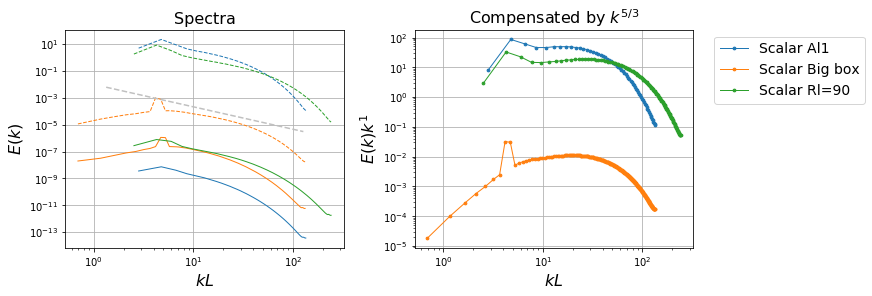

In [13]:
fig, ax = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(12,4))

for i,simu in enumerate(simulations) :
    xscaling = simu['L']
    #xscaling = 1.0
    ax[0].plot(simu['vel_k']*xscaling, simu['vel_spec']*4.0*np.pi*(simu['vel_k']**2)/simu['vel_nb_of_modes'], '-', lw=1.0, markersize=5.5, color=colors[i], label='Velocity')
    ax[0].plot(simu['k']*xscaling, simu['scal_spec']*4.0*np.pi*(simu['k']**2)/simu['nb_of_modes'], '--', lw=1.0, markersize=5.5, color=colors[i], label='Scalar %2.0f' % i)
    
    #ax[1].plot(simu['vel_k']*xscaling, simu['vel_spec']*4.0*np.pi*(simu['vel_k']**2)/simu['vel_nb_of_modes']*(simu['vel_k']**(5.0/3.0)), '-', lw=1.0, markersize=5.5, color=colors[i], label='Velocity ' + simu['label'])
    ax[1].plot(simu['k']*xscaling, simu['scal_spec']*4.0*np.pi*(simu['k']**2)/simu['nb_of_modes']*(simu['k']**(5/3)), '.-', lw=1.0, markersize=5.5, color=colors[i], label='Scalar ' + simu['label'])
ax[0].plot(simu['k'], 1e-2*simu['k']**(-5.0/3.0), 'k--', label=r'$k^{-5/3}$', color='silver')
ax[0].set(xscale='log', yscale='log', xlabel=r'$kL$', ylabel=r'$E(k)$', title=r'Spectra'); ax[0].grid()
ax[1].set(xscale='log', yscale='log', xlabel=r'$kL$', ylabel=r'$E(k)k^{1}$', title=r'Compensated by $k^{5/3}$'); ax[1].grid()
lgd = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# pp = PdfPages('../Images/Scalar/spec_scalar_compens_eps43_N192_diff_u.pdf')
# pp.savefig(bbox_extra_artists=lgd,), bbox_inches='tight')
# pp.close()

plt.show()

# 2-point time correlations

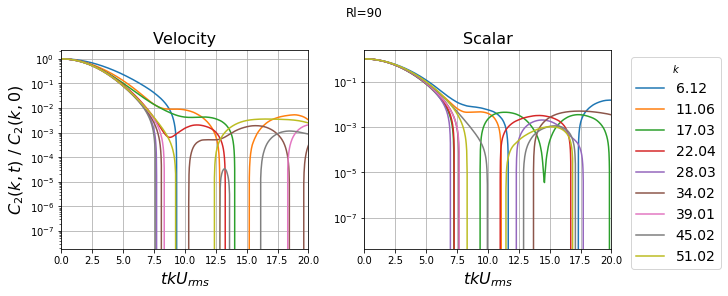

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(10,4.0))
simu = simulations[-1]
fig.suptitle(simu['label'])
for ik in simu['indices_of_k_to_plot'] :
#for ik in [6,7,8,9] :
    scaling = simu['Urms']*simu['k'][ik]
    ax[0].plot(simu['vel_t']*scaling, simu['vel_corr'][:,ik]/simu['vel_corr'][0,ik], '-', label=r'%2.2f' % (simu['k'][ik]))
    ax[1].plot(simu['scalar_t'][1:]*scaling, simu['scalar_corr'][1:,ik]/simu['scalar_corr'][1,ik], '-', label=r'%2.2f' % (simu['k'][ik]))
ax[0].set(xscale='linear',yscale='log', xlabel=r'$t k U_{rms}$', ylabel=r'$C_2(k,t) \ / \ C_2(k,0)$', title=r'Velocity'); ax[0].grid()
ax[1].set(xscale='linear',yscale='log', xlabel=r'$t k U_{rms}$', title=r'Scalar'); ax[1].grid()

x_max = 20.0
ax[0].set(xlim=[0,x_max]); ax[1].set(xlim=[0,x_max])
leg = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k$')

# pp = PdfPages('../Images/Scalar/vel_and_scalar_corr_Rl90_Sc07.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

In [15]:
#fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(11,5))
#simu = simulations[0]
#for i, ik in enumerate(simu['indices_of_k_to_plot2']) :
#    scaling = simu['Urms']*simu['k'][ik]
#    normalization1 = 1.0/np.sqrt(simu['vel_avg_sqr'][0,ik]*simu['vel_avg_sqr'][:,ik])
#    normalization2 = 1.0/(simu['vel_corr_norms'][0,ik]-simu['vel_avg_norms'][0,ik]*simu['vel_avg_norms'][0,ik])
#    ax.plot(simu['vel_t']*scaling, (simu['vel_corr_norms'][:,ik]-simu['vel_avg_norms'][0,ik]*simu['vel_avg_norms'][:,ik])*normalization1, \
#            '-', label=r'%2.2f' % (simu['k'][ik]),color=colors[i])
#    ax.plot(simu['vel_t']*scaling, (simu['vel_corr_norms'][:,ik]-simu['vel_avg_norms'][0,ik]*simu['vel_avg_norms'][:,ik])*normalization2, '--',color=colors[i])
#ax.set(xscale='linear',yscale='log', xlabel=r'$t k U_{rms}$', ylabel=r'$C_2(k,t) \ / \ C_2(k,0)$', title=r'Velocity'); ax.grid()

#x_max = 10.0; ymin = 1e-3
#ax.set(xlim=[0,x_max], ylim=[ymin,1.1])
#leg = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k$')

# pp = PdfPages('../Images/Scalar/vel_and_scalar_corr_Rl90_Sc07.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
#plt.show()

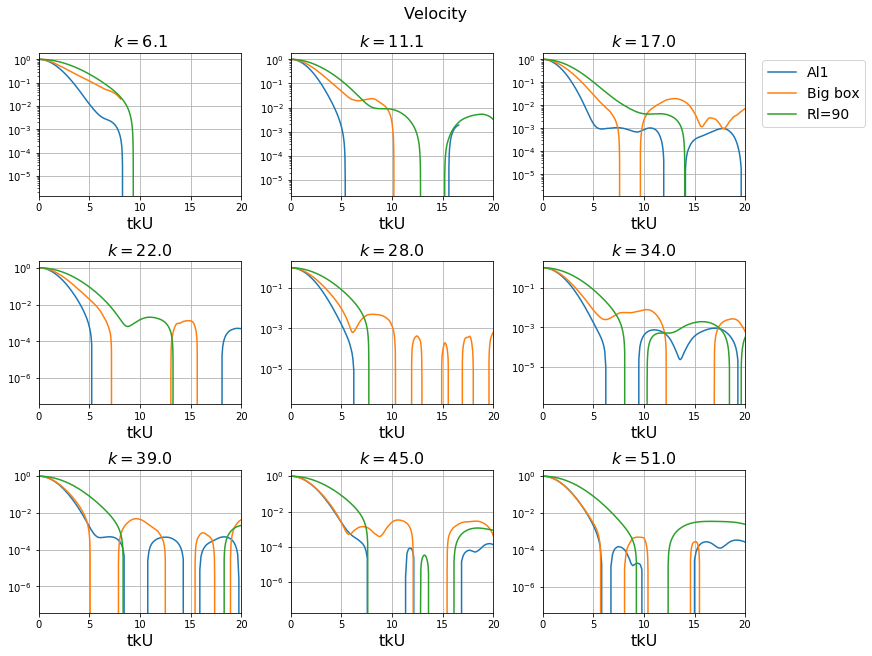

In [16]:
nb_of_rows = 3
nb_of_columns = 3
table = simulations[0]['indices_of_k_to_plot'].reshape(nb_of_rows,nb_of_columns)

fig, ax = plt.subplots(nrows=nb_of_rows, ncols=nb_of_columns, figsize=(nb_of_columns*3+3,nb_of_rows*3), squeeze=False, constrained_layout=True)
fig.suptitle('Velocity', fontsize=16)
for index_plot, ik in np.ndenumerate(table):
    for index_simu, simu in enumerate(simulations) :
        scaling = simu['k'][ik]*simu['Urms']
        ax[index_plot].plot(simu['vel_t']*scaling, simu['vel_corr'][:,ik]/simu['vel_corr'][0,ik], '-', label=simu['label'], color=colors[index_simu])
        #ax[index_plot].plot(simu['vel_t']*scaling, simu['vel_avg'][:,ik]*simu['vel_avg'][0,ik], ':', label=simu['folder'], color=colors[index_simu])
        #ax[index_plot].plot(simu['vel_t'][1:]*scaling, special.jv(1, 2.0*simu['vel_t'][1:]*scaling)/(simu['vel_t'][1:]*scaling), '--', label=simu['folder'], color=colors[index_simu])
        #ax[index_plot].plot(simu['vel_t']*scaling, simu['vel_corr_norms'][:,ik], '--', label=simu['folder'], color=colors[index_simu])
        #ax[index_plot].plot(simu['vel_t']*scaling, simu['vel_avg_norms'][:,ik]*simu['vel_avg_norms'][0,ik], '-.', label=simu['folder'], color=colors[index_simu])
        #ax[index_plot].plot(simu['vel_t']*scaling, simu['vel_corr_norms'][:,ik]-simu['vel_avg_norms'][:,ik]*simu['vel_avg_norms'][0,ik], ':', label=simu['folder'], color=colors[index_simu])
        #ax[index_plot].plot(simu['vel_t']*scaling, (simu['vel_corr_norms'][:,ik]-simu['vel_avg_norms'][0,ik]*simu['vel_avg_norms'][:,ik])/(simu['vel_corr_norms'][0,ik]-simu['vel_avg_norms'][0,ik]**2), '--', label=simu['folder'], color=colors[index_simu])
        #ax[index_plot].plot(simu['vel_t']*scaling, (simu['vel_corr_sqr'][:,ik]-simu['vel_avg_sqr'][0,ik]*simu['vel_avg_sqr'][:,ik])/(simu['vel_corr_sqr'][0,ik]-simu['vel_avg_sqr'][0,ik]**2), ':', label=simu['folder'], color=colors[index_simu])        
    ax[index_plot].set(xscale='linear', yscale='log', xlabel='tkU', title=r'$k=%2.1f$' % simu['k'][ik])
    ax[index_plot].set(xlim=[0,20])
    ax[index_plot].grid()
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

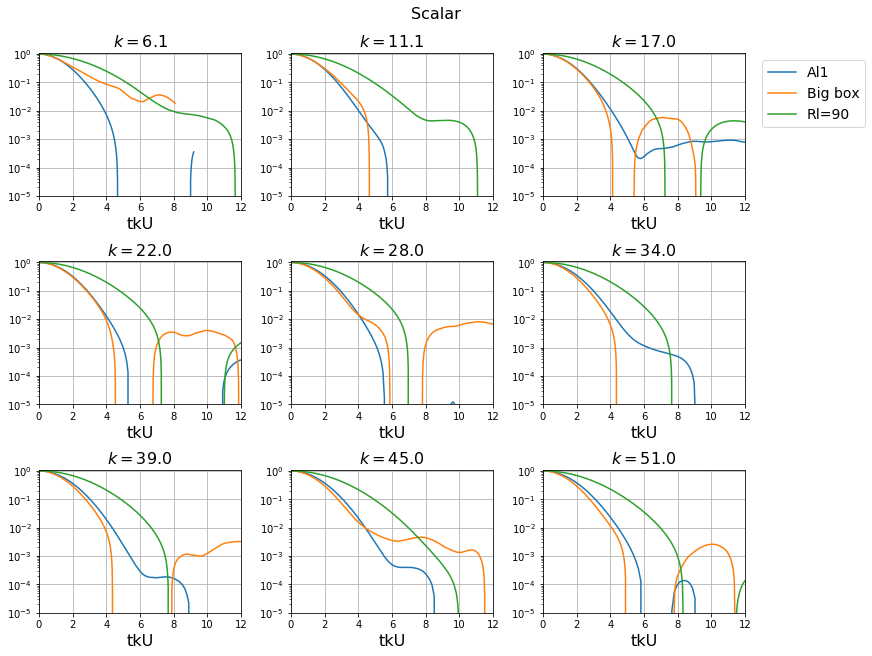

In [17]:
nb_of_rows = 3
nb_of_columns = 3
table = simulations[0]['indices_of_k_to_plot'].reshape(nb_of_rows,nb_of_columns)

fig, ax = plt.subplots(nrows=nb_of_rows, ncols=nb_of_columns, figsize=(nb_of_columns*3+3,nb_of_rows*3), squeeze=False, constrained_layout=True)
fig.suptitle('Scalar', fontsize=16)
for index_plot, ik in np.ndenumerate(table):
    for index_simu, simu in enumerate(simulations) :
        scaling = simu['k'][ik]*simu['Urms']
        ax[index_plot].plot(simu['scalar_t']*scaling, simu['scalar_corr'][:,ik]/simu['scalar_corr'][1,ik], '-', label=simu['label'], color=colors[index_simu])
        #ax[index_plot].plot(simu['scalar_t']*scaling, simu['scalar_avg'][:,ik], ':', label=simu['folder'], color=colors[index_simu])
        #ax[index_plot].plot(simu['scalar_t']*scaling, (simu['scalar_sqr_corr'][:,ik]-simu['scalar_sqr_avg'][:,ik]*simu['scalar_sqr_avg'][0,ik])/(simu['scalar_sqr_corr'][0,ik]-simu['scalar_sqr_avg'][0,ik]*simu['scalar_sqr_avg'][0,ik]), '--', label=simu['folder'], color=colors[index_simu])
    ax[index_plot].set(xscale='linear', yscale='log', xlabel='tkU', title=r'$k=%2.1f$' % simu['k'][ik])
    ax[index_plot].set(xlim=[0,12], ylim=[10e-6,1.1])
    ax[index_plot].grid()
ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Crossover

In [18]:
# compute time derivatives of the corr function
for simu in simulations : 
    simu['deriv1'] = np.ndarray(shape=(len(simu['k']), len(simu['scalar_t'])-1), dtype=float)
    simu['deriv2'] = np.ndarray(shape=(len(simu['k']), len(simu['scalar_t'])-1), dtype=float)
    simu['deriv1_vel'] = np.ndarray(shape=(len(simu['k']), len(simu['vel_t'])-1), dtype=float)
    for ik in range(len(simu['k'])) :
        sl = np.s_[1:len(simu['scalar_t'])]
        #data = np.cumsum(simu['scalar_corr'][:,ik]/simu['scalar_corr'][0,ik])
        data = np.log(simu['scalar_corr'][:,ik])
        simu['deriv1'][ik,:] = np.gradient(data[sl], simu['scalar_t'][sl], edge_order=1)
        simu['deriv2'][ik,:] = np.gradient(simu['deriv1'][ik,:] / (simu['scalar_corr'][sl,ik] / simu['scalar_corr'][1,ik]), simu['scalar_t'][sl], edge_order=1)
        #simu['deriv1'][ik,:] = np.gradient(np.log(np.abs(simu['scalar_corr'][sl,ik] / simu['scalar_corr'][1,ik])), np.log(simu['scalar_t'][sl]), edge_order=1)
    for ik in range(len(simu['vel_k'])) :    
        simu['deriv1_vel'][ik,:] = np.gradient(np.log(simu['vel_corr'][sl,ik]), simu['vel_t'][sl], edge_order=1)
        #simu['deriv1_vel'][ik,:] = np.gradient(np.cumsum(simu['scalar_corr'][sl,ik]/simu['scalar_corr'][0,ik]), simu['vel_t'][sl], edge_order=1)

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


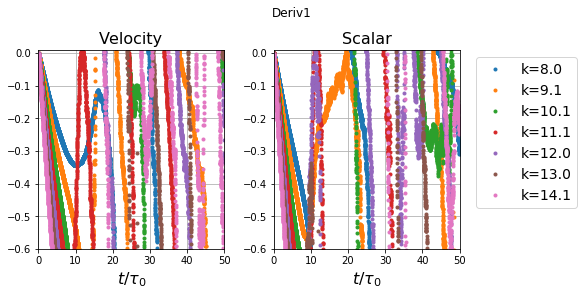

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), constrained_layout=True)
fig.suptitle('Deriv1')
simu = simulations[-1]
sl=np.s_[1::]
#for ik in simulations[1]['indices_of_k_to_plot2'][3:8] :
#for ik in [3,7,10,15,55] :
for i,ik in enumerate([7,8,9,10,11,12,13]) :
    scaling = 1.0
    ax[0].plot(scaling*simu['vel_t'][sl],simu['deriv1_vel'][ik], '.', label='k=%2.1f' % (simu['k'][ik]))
    ax[1].plot(scaling*simu['scalar_t'][sl],simu['deriv1'][ik],  '.', label='k=%2.1f' % (simu['k'][ik]))
    #ax[0].plot(scaling*simu['vel_t'][sl],simu['deriv1_vel'][ik], '.', label='k=%2.1f' % (simu['k'][ik]))
    #ax[1].plot(scaling*simu['scalar_t'][sl],simu['deriv1'][ik],  '.', label='k=%2.1f' % (simu['k'][ik]))
ax[0].set(xlim=[0,100],ylim=(-0.01,0.02),  xlabel=r'$t/\tau_0$', title='Velocity'); ax[0].grid()
ax[1].set(xlabel=r'$t/\tau_0$', title='Scalar', yscale='linear'); ax[1].grid()
for plot_ax in ax:
    plot_ax.set(xlim=[0,50],ylim=(-0.6,0.01))
#ax.axvline(x=simu['Te'], color='k')
lgd = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

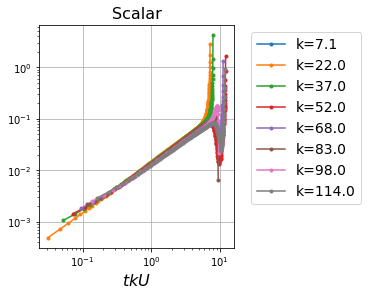

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), constrained_layout=True)
simu = simulations[-1]
for iik,ik in enumerate(np.linspace(6,simu['N']//2-15,8, dtype=int)) :
    end_of_slice = np.where(simu['deriv1'][ik] > 0)[0][0]
    sl=np.s_[2:end_of_slice:]
    scaling = simu['k'][ik]*simu['Urms']
    ax.plot(scaling*simu['scalar_t'][sl],-simu['deriv1'][ik][sl]/(simu['k'][ik]),  '.-', label='k=%2.1f' % (simu['k'][ik]))
ax.set(xlabel=r'$tk U$', title='Scalar', yscale='log', xscale='log'); ax.grid()
#ax.set(xlim=[0.0,15.0],ylim=(-0.25,0.1))
#ax.axvline(x=simu['Te'], color='k')
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Correlation fit

In [21]:
def poly_gaussian(x, a, b, c):   
    return np.exp(-a * (x)**2.0 + b*x + c) 
def poly_gaussian_jacobian(x, a, b, c):   
    return np.transpose([-(x**2.0)*np.exp(-a * (x)**2.0 +b*x + c), x*np.exp(-a * (x)**2.0 + b*x + c) ,np.exp(-a * (x)**2.0 + b*x + c)])

def simple_gaussian(x, a, c):   
    return np.exp(-a * (x)**2.0 + c) 
def simple_gaussian_jacobian(x, a, c):   
    return np.transpose([-(x**2.0)*np.exp(-a * (x)**2.0 + c), np.exp(-a * (x)**2.0 + c)])

def simple_exp(x, a, c):   
    return np.exp(-a * x + c) 
def simple_exp_jacobian(x, a, c):   
    return np.transpose([-x*np.exp(-a * x + c), np.exp(-a * x + c)])

def linear_fun(x, a, b):   
    return (a * x + b) 
def linear_jacobian(x, a, b):   
    return np.transpose([x, np.ones_like(x)])

## Fitting (iterative method)

Fitting the scalars correlations function $f(x) = \exp\{-a x^2 +b x + c \}$ 
with $x = t/\tau_0$, $y = C^2(t,k)/C^2(t=0,k)$ :

In [22]:
tk_end_fit = 2.0
nb_of_params = 2
for simu in simulations :
    simu['fit_coef'] = np.zeros((len(simu['k']), nb_of_params), dtype=float); simu['fit_coef_error'] = np.zeros((len(simu['k']), nb_of_params), dtype=float)
    simu['chi2'] = np.zeros(len(simu['k']), dtype=float)
    for ik, k in enumerate(simu['k']) :
        xdata = simu['scalar_t']/simu['t0']
        ydata = (simu['scalar_corr'][:,ik])/simu['scalar_corr'][1,ik]
        #a = np.searchsorted(xdata, 0.0)
        a = 1
        b = np.searchsorted(xdata*k*simu['L'], tk_end_fit)
        if ((b-a) > 3) :
            coef, covar = curve_fit(simple_gaussian, xdata[a:b], ydata[a:b], jac=simple_gaussian_jacobian, absolute_sigma=False)
            simu['fit_coef'][ik] = coef
            simu['fit_coef_error'][ik] = np.sqrt(np.diagonal(covar))
            simu['chi2'][ik] = np.sum((ydata-simple_gaussian(xdata,*coef))**2)

Fitting the velocity correlations functions :

In [23]:
for simu in simulations :
    simu['vel_fit_coef'] = np.zeros((len(simu['k']), nb_of_params), dtype=float); simu['vel_fit_coef_error'] = np.zeros((len(simu['k']), nb_of_params), dtype=float)
    simu['vel_fit_chi2'] = np.zeros(len(simu['k']), dtype=float)
    for ik, k in enumerate(simu['vel_k']) :
        xdata = simu['vel_t']/simu['t0']
        ydata = simu['vel_corr'][:,ik]/simu['vel_corr'][0,ik]
        a = 0
        b = np.searchsorted(xdata*k*simu['L'], tk_end_fit)
        if ((b-a) > 3) :
            coef, covar = curve_fit(simple_gaussian, xdata[a:b], ydata[a:b], jac=simple_gaussian_jacobian, absolute_sigma=False)
            simu['vel_fit_coef'][ik] = coef
            simu['vel_fit_coef_error'][ik] = np.sqrt(np.diagonal(covar))
            simu['vel_fit_chi2'][ik] = np.sum((ydata-simple_gaussian(xdata,*coef))**2)

Plot results of fitting :

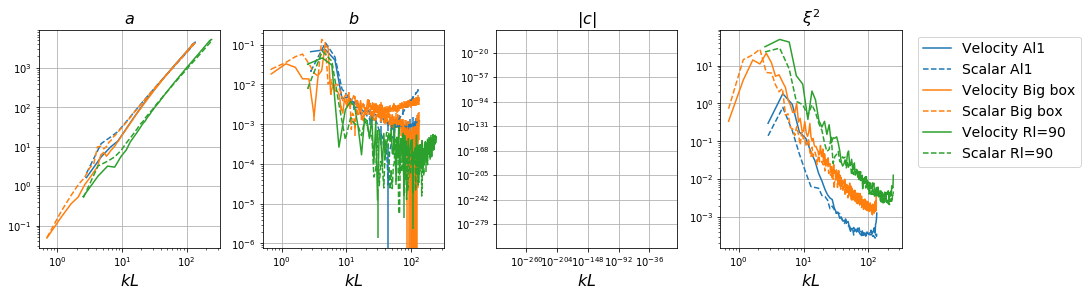

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=4, constrained_layout=True,figsize=(15,4))

for i,simu in enumerate(simulations) : 
    xscaling = simu['L']
    ax[0].errorbar(simu['k']*xscaling, simu['vel_fit_coef'][:,0], yerr=simu['vel_fit_coef_error'][:,0],errorevery=5, color=colors[i])
    ax[1].errorbar(simu['k']*xscaling, np.abs(simu['vel_fit_coef'][:,1]), yerr=simu['vel_fit_coef_error'][:,1],errorevery=5, color=colors[i])
    #ax[2].errorbar(simu['k']*xscaling, np.abs(simu['vel_fit_coef'][:,2]), yerr=simu['vel_fit_coef_error'][:,1],errorevery=5, color=colors[i])
    ax[3].plot(simu['k']*xscaling, simu['vel_fit_chi2'], label='Velocity ' + simu['label'], color=colors[i])
    ax[0].errorbar(simu['k']*xscaling, simu['fit_coef'][:,0], yerr=simu['fit_coef_error'][:,0],errorevery=5, ls='--', color=colors[i])
    ax[1].errorbar(simu['k']*xscaling, np.abs(simu['fit_coef'][:,1]), yerr=simu['fit_coef_error'][:,1],errorevery=5, ls='--', color=colors[i])
    #ax[2].errorbar(simu['k']*xscaling, np.abs(simu['fit_coef'][:,2]), yerr=simu['fit_coef_error'][:,2],errorevery=5, ls='--', color=colors[i])
    ax[3].plot(simu['k']*xscaling, simu['chi2'], label='Scalar ' + simu['label'], ls='--', color=colors[i])
ax[0].set(xlabel=r'$kL$', title=r'$a$', yscale='log', xscale='log'); ax[0].grid()
ax[1].set(xlabel=r'$kL$', title=r'$b$', yscale='log', xscale='log'); ax[1].grid()
ax[2].set(xlabel=r'$kL$', title=r'$|c|$', yscale='log', xscale='log'); ax[2].grid()
ax[3].set(xlabel=r'$kL$', title=r'$\xi^2$', yscale='log', xscale='log'); ax[3].grid()
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## Compare Gaussian part of the fit and data

In [45]:
threshold = 2e-3
for i,simu in enumerate(simulations) : 
    simu['it_cut-off'] = np.zeros_like(simu['k'], dtype=int)
    for ik, k in enumerate(simu['k']) :
        small_amplitudes = np.argwhere(simu['scalar_corr'][:,ik]/simu['scalar_corr'][0,ik]<threshold)
        if (len(small_amplitudes) > 0) :
            simu['it_cut-off'][ik] = small_amplitudes[0,0]
        else :
            simu['it_cut-off'][ik] = len(simu['scalar_t']) - 1

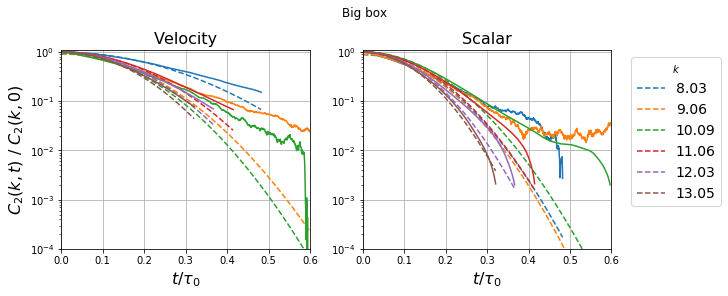

In [46]:
simu = simulations[1]

fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(10,4))
fig.suptitle(simu['label'])
#for i,ik in enumerate([2,3,4,5,6,7,8,9]) :
for i,ik in enumerate([7,8,9,10,11,12]) :
#for i,ik in enumerate(simu['indices_of_k_to_plot'][:]) :
    time_sl = np.s_[0:simu['it_cut-off'][ik]]
    scaling = simu['Urms']
    ax[0].plot(simu['vel_t'][time_sl]*scaling, simu['vel_corr'][time_sl,ik]/simu['vel_corr'][0,ik], '-', color=colors[i])
    ax[0].plot(simu['vel_t'][time_sl]*scaling, np.exp(-simu['vel_fit_coef'][ik][0]*(simu['vel_t'][time_sl]/simu['t0'])**2 + simu['vel_fit_coef'][ik][1]), '--', color=colors[i])
    ax[1].plot(simu['scalar_t'][time_sl]*scaling, simu['scalar_corr'][time_sl,ik]/simu['scalar_corr'][0,ik], '-', color=colors[i])
    #ax[1].plot(simu['scalar_t']*scaling, np.exp(simu['fit_coef'][ik][1]*(simu['scalar_t']/simu['t0']) + simu['fit_coef'][ik][2]), ':', color=colors[i])
    ax[1].plot(simu['scalar_t'][time_sl]*scaling, np.exp(-simu['fit_coef'][ik][0]*(simu['scalar_t'][time_sl]/simu['t0'])**2 + simu['fit_coef'][ik][1]), '--', label=r'%2.2f' % (simu['k'][ik]), color=colors[i])
ax[0].set(xscale='linear',yscale='log', xlabel=r'$t/\tau_0$', ylabel=r'$C_2(k,t) \ / \ C_2(k,0)$', title=r'Velocity'); ax[0].grid()
ax[1].set(xscale='linear',yscale='log', xlabel=r'$t/\tau_0$', title=r'Scalar'); ax[1].grid()

x_max = 0.6
ax[0].set(xlim=[0,x_max], ylim=[10e-5,1.1])
ax[1].set(xlim=[0,x_max], ylim=[10e-5,1.1])
leg = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k$')

# pp = PdfPages('../Images/Scalar/vel_and_scalar_corr_Rl90_Sc07.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

# Deviation from Gaussian

In [47]:
threshold_gaussian_deviation = 10e-3
for i,simu in enumerate(simulations) : 
    simu['it_deviation'] = np.zeros_like(simu['k'], dtype=int)
    for ik, k in enumerate(simu['k']) :
        large_deviations = np.argwhere((np.abs(simu['scalar_corr'][:,ik]/simu['scalar_corr'][0,ik] - np.exp(-simu['fit_coef'][ik][0]*(simu['scalar_t'][:]/simu['t0'])**2 + simu['fit_coef'][ik][1]))/np.exp(-simu['fit_coef'][ik][0]*(simu['scalar_t'][:]/simu['t0'])**2 + simu['fit_coef'][ik][1]))>threshold_gaussian_deviation)
        if (len(large_deviations) > 0) :
            simu['it_deviation'][ik] = large_deviations[0,0]
        else :
            simu['it_deviation'][ik] = len(simu['scalar_t']) - 1

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in true_divide
  """
/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in true_divide
  from ipykernel import kernelapp as app
/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in true_divide
  app.launch_new_instance()


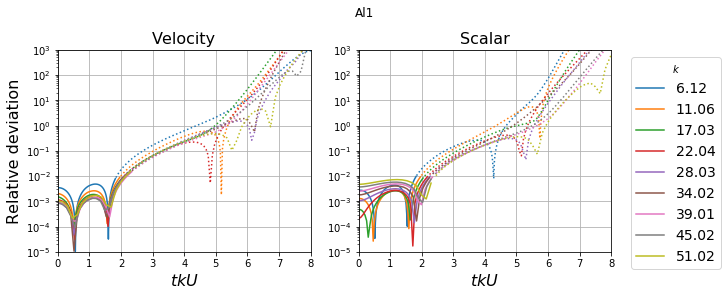

In [48]:
simu = simulations[0]

fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(10,4))
fig.suptitle(simu['label'])
#for i,ik in enumerate([2,3,4,5,6,7,8,9]) :
#for i,ik in enumerate([7,8,9,10,11,12]) :
for i,ik in enumerate(simu['indices_of_k_to_plot'][:]) :
    scaling = simu['k'][ik]*simu['Urms']
    #time_sl = np.s_[0:simu['it_cut-off'][ik]]
    time_sl = np.s_[0:simu['it_deviation'][ik]]
    ax[0].plot(simu['vel_t'][time_sl]*scaling, np.abs(simu['vel_corr'][time_sl,ik]/simu['vel_corr'][0,ik] - np.exp(-simu['vel_fit_coef'][ik][0]*(simu['vel_t'][time_sl]/simu['t0'])**2 + simu['vel_fit_coef'][ik][1]))/np.exp(-simu['vel_fit_coef'][ik][0]*(simu['vel_t'][time_sl]/simu['t0'])**2 + simu['vel_fit_coef'][ik][1]), '-', color=colors[i])
    ax[1].plot(simu['scalar_t'][time_sl]*scaling, np.abs(simu['scalar_corr'][time_sl,ik]/simu['scalar_corr'][0,ik] - np.exp(-simu['fit_coef'][ik][0]*(simu['scalar_t'][time_sl]/simu['t0'])**2 + simu['fit_coef'][ik][1]))/np.exp(-simu['fit_coef'][ik][0]*(simu['scalar_t'][time_sl]/simu['t0'])**2 + simu['fit_coef'][ik][1]), '-', label=r'%2.2f' % (simu['k'][ik]),  color=colors[i])
    
    time_sl = np.s_[simu['it_deviation'][ik]::]
    ax[0].plot(simu['vel_t'][time_sl]*scaling, np.abs(simu['vel_corr'][time_sl,ik]/simu['vel_corr'][0,ik] - np.exp(-simu['vel_fit_coef'][ik][0]*(simu['vel_t'][time_sl]/simu['t0'])**2 + simu['vel_fit_coef'][ik][1]))/np.exp(-simu['vel_fit_coef'][ik][0]*(simu['vel_t'][time_sl]/simu['t0'])**2 + simu['vel_fit_coef'][ik][1]), ':', color=colors[i])
    ax[1].plot(simu['scalar_t'][time_sl]*scaling, np.abs(simu['scalar_corr'][time_sl,ik]/simu['scalar_corr'][0,ik] - np.exp(-simu['fit_coef'][ik][0]*(simu['scalar_t'][time_sl]/simu['t0'])**2 + simu['fit_coef'][ik][1]))/np.exp(-simu['fit_coef'][ik][0]*(simu['scalar_t'][time_sl]/simu['t0'])**2 + simu['fit_coef'][ik][1]), ':',color=colors[i])
        
ax[0].set(xscale='linear',yscale='log', xlabel=r'$t k U$', ylabel=r'Relative deviation', title=r'Velocity'); ax[0].grid()
ax[1].set(xscale='linear',yscale='log', xlabel=r'$t k U$', title=r'Scalar'); ax[1].grid()

x_max = 8.0
for axes in ax :
    axes.set(xlim=[0,x_max], ylim=[10e-6,1000])

leg = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k$')

# pp = PdfPages('../Images/Scalar/vel_and_scalar_corr_Rl90_Sc07.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

# Correlations after Gaussian

In [49]:
for i,simu in enumerate(simulations) : 
    simu['scalar_large_time_fit'] = np.zeros([len(simu['k']),2])
    simu['vel_large_time_fit'] = np.zeros([len(simu['k']),2])
    for ik, k in enumerate(simu['k']) :
        time_sl = np.s_[simu['it_deviation'][ik]:simu['it_cut-off'][ik]]
        x = simu['scalar_t'][time_sl]
        y = np.log(simu['scalar_corr'][time_sl,ik])
        if (len(y) > 0) :
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            simu['scalar_large_time_fit'][ik] = [slope, intercept]
        
            y = np.log(simu['vel_corr'][time_sl,ik])
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            simu['vel_large_time_fit'][ik] = [slope, intercept]

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


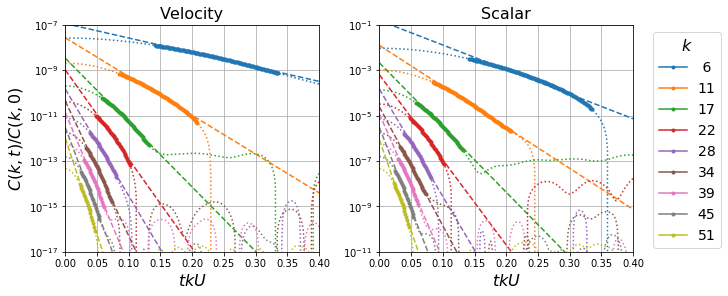

In [70]:
simu = simulations[0]

fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(10,4))
#fig.suptitle(simu['label'])
#for i,ik in enumerate([2,3,4,5,6,7,8,9]) :
#for i,ik in enumerate([7,8,9,10,11,12]) :
for i,ik in enumerate(simu['indices_of_k_to_plot'][:]) :
    horizontal_scaling = simu['k'][ik]*simu['Urms']
    horizontal_scaling = 1.0/simu['t0']
    vertical_scaling = 1.0
    #time_sl = np.s_[0:simu['it_cut-off'][ik]]
    time_sl0 = np.s_[:simu['it_deviation'][ik]]
    time_sl1 = np.s_[simu['it_deviation'][ik]:simu['it_cut-off'][ik]]
    time_sl2 = np.s_[simu['it_cut-off'][ik]:]
    ax[0].plot(simu['vel_t'][time_sl0]*horizontal_scaling, simu['vel_corr'][time_sl0,ik]*vertical_scaling, ':', color=colors[i])
    ax[0].plot(simu['vel_t'][time_sl1]*horizontal_scaling, simu['vel_corr'][time_sl1,ik]*vertical_scaling, '.-', color=colors[i])
    ax[0].plot(simu['vel_t'][time_sl2]*horizontal_scaling, simu['vel_corr'][time_sl2,ik]*vertical_scaling, ':', color=colors[i])
    ax[0].plot(simu['vel_t']*horizontal_scaling, np.exp(simu['vel_large_time_fit'][ik][0]*simu['vel_t'] + simu['vel_large_time_fit'][ik][1])*vertical_scaling, '--', color=colors[i])
    ax[1].plot(simu['scalar_t'][time_sl0]*horizontal_scaling, simu['scalar_corr'][time_sl0,ik]*vertical_scaling, ':', color=colors[i])
    ax[1].plot(simu['scalar_t'][time_sl1]*horizontal_scaling, simu['scalar_corr'][time_sl1,ik]*vertical_scaling, '.-', label=r'%2.0f' % (simu['k'][ik]),  color=colors[i])
    ax[1].plot(simu['scalar_t'][time_sl2]*horizontal_scaling, simu['scalar_corr'][time_sl2,ik]*vertical_scaling, ':', color=colors[i])
    ax[1].plot(simu['scalar_t']*horizontal_scaling, np.exp(simu['scalar_large_time_fit'][ik][0]*simu['scalar_t'] + simu['scalar_large_time_fit'][ik][1])*vertical_scaling, '--', color=colors[i])
    
ax[0].set(xscale='linear',yscale='log', xlabel=r'$tk U$', ylabel=r'$C(k,t)/C(k,0)$', title=r'Velocity'); ax[0].grid()
ax[1].set(xscale='linear',yscale='log', xlabel=r'$t k U$', title=r'Scalar'); ax[1].grid()

x_max = 0.4
ax[0].set(xlim=[0,x_max])
ax[1].set(xlim=[0,x_max])
ax[1].set(ylim=[10e-12,0.1])
ax[0].set(ylim=[10e-18,1e-7])

leg = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k$', title_fontsize=16)

# pp = PdfPages('../Images/Scalar/large_times.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

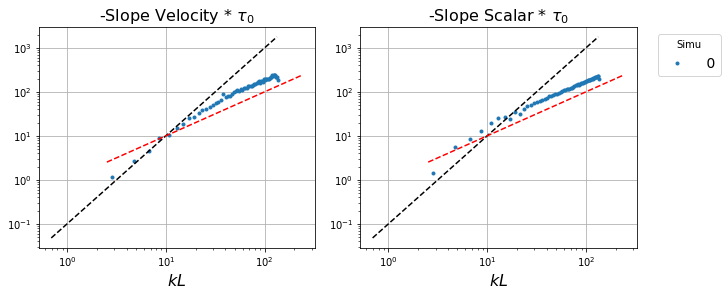

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(10,4))

for i,simu in enumerate(simulations[:1]) : 
    xscaling = simu['L']
    ax[0].plot(simu['k']*xscaling, -simu['vel_large_time_fit'][:,0]*simu['t0'], '.', color=colors[i])
    ax[1].plot(simu['k']*xscaling, -simu['scalar_large_time_fit'][:,0]*simu['t0'], '.', color=colors[i], label='%2.0i' %i)
#    ax[1].plot(simu['k']*xscaling, np.abs(simu['vel_fit_coef'][:,1]), color=colors[i])
#    ax[0].plot(simu['k']*xscaling, simu['vel_large_time_fit'][:,0], ls='--', color=colors[i])
#    ax[1].plot(simu['k']*xscaling, np.abs(simu['fit_coef'][:,1]), ls='--', color=colors[i])

simu=simulations[1]
ax[0].plot(simu['k']*simu['L'], 1e-1*(simu['k']*simu['L'])**2, 'k--')
ax[1].plot(simu['k']*simu['L'], 1e-1*(simu['k']*simu['L'])**2, 'k--')

simu=simulations[2]
ax[0].plot(simu['k']*simu['L'], 1e0*(simu['k']*simu['L'])**1, 'r--')
ax[1].plot(simu['k']*simu['L'], 1e0*(simu['k']*simu['L'])**1, 'r--')

ax[0].set(xlabel=r'$kL$', title=r'-Slope Velocity * $\tau_0$', yscale='log', xscale='log'); ax[0].grid()
ax[1].set(xlabel=r'$kL$', title=r'-Slope Scalar * $\tau_0$', yscale='log', xscale='log'); ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Simu')

plt.show()

# Physical fields

In [32]:
import h5py

In [33]:
for simu in simulations :
    # Read scalar field
    try :
        scal = np.empty([simu['N'], simu['N'], simu['N']])
        file_name = common_folder + simu['folder'] + 'run1/' + 'ScalarS1_' + "%06d" % simu['h5_ite'] + '.h5'
        print('Reading file' + file_name)
        file = h5py.File(file_name, 'r')
        simu['scal_field'] = file['ScalarS1'][:,:] # copy the file data into a numpy array
        file.close()
    except : 
        simu['scal_field'] = np.zeros((simu['N'],simu['N'],simu['N']))
    # Read velocity fields
    try :
        scal = np.empty([simu['N'], simu['N'], simu['N']])
        file_name = common_folder + simu['folder'] + 'run1/' + 'U_' + "%06d" % simu['h5_ite'] + '.h5'
        file = h5py.File(file_name, 'r')
        print('Reading file' + file_name)
        simu['U'] = file['U'][:,:] # copy the file data into a numpy array
        file.close()
    except : 
        simu['U'] = np.zeros((simu['N'],simu['N'],simu['N']))

Reading file/home/gorbunov8a/data/scalar/N128/Rl60_Sc07/run1/ScalarS1_500000.h5
Reading file/home/gorbunov8a/data/scalar/N128/Rl60_Sc07/run1/U_500000.h5
Reading file/home/gorbunov8a/data/scalar/N512/Rl60_Sc10_forcing8/run1/ScalarS1_018000.h5
Reading file/home/gorbunov8a/data/scalar/N256/Rl90_Sc07/run1/ScalarS1_165000.h5
Reading file/home/gorbunov8a/data/scalar/N256/Rl90_Sc07/run1/U_165000.h5


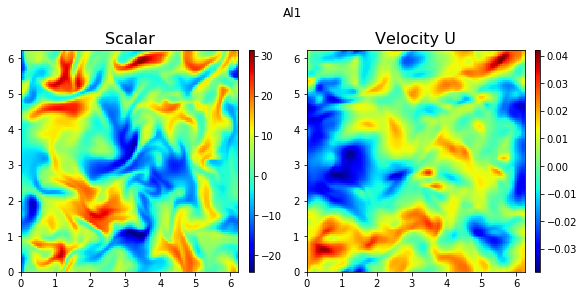

In [34]:
simu = simulations[0]
x_scal = 2.0*np.pi/simu['N']*np.arange(0,simu['N'])
x_cut=40

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), constrained_layout=True)
fig.suptitle(simu['label'])
im = ax[0].pcolormesh(x_scal, x_scal, simu['scal_field'][x_cut, :,:], cmap='jet')
ax[0].set(xscale='linear', yscale='linear', title='Scalar')
fig.colorbar(im, ax=ax[0], aspect=100)

im = ax[1].pcolormesh(x_scal, x_scal, simu['U'][x_cut, :,:], cmap='jet')
ax[1].set(xscale='linear', yscale='linear', title='Velocity U')
fig.colorbar(im, ax=ax[1], aspect=100)

#plt.savefig("../Images/Scalar/fields_eps43_N192_diff_u.png", dpi=150, format="png")
plt.show()

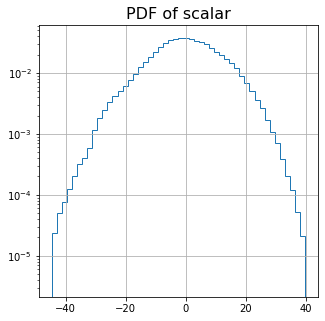

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
#plot histogram
nb_of_bins=50
simu = simulations[0]
ax.hist(x=simu['scal_field'].flatten(), bins=nb_of_bins, histtype='step', density=True, log=True, align='mid')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set(title='PDF of scalar'); ax.grid()
plt.show()